In [107]:
import torch
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def biggest_contour(contours, min_area):
    biggest = None
    max_area = 0
    biggest_n = 0
    approx_contour = None
    for n, i in enumerate(contours):
        area = cv2.contourArea(i)

        if area > min_area / 30:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
                biggest_n = n
                approx_contour = approx

    return biggest_n, approx_contour


def order_points(pts):
    pts = pts.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect



def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped




# 0. Segmentation

# Qunaitize and make script

In [420]:
from models.u2net import REBNCONV, U2NETP
import copy

segment = U2NETP(out_ch=1)#.to(device)

segmentation_model_path = './weights/segmentation_0409_256px_fin.pth'
segment.load_state_dict(torch.load(segmentation_model_path))


norm_mean = [ 0.485, 0.456, 0.406 ]
norm_std  = [ 0.229, 0.224, 0.225 ]

loader = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize(mean = norm_mean, std = norm_std),
])

In [437]:
segment_cpu = copy.deepcopy(segment.to('cpu'))
segment_cpu_non_quant = copy.deepcopy(segment.to('cpu'))

segment_cpu.eval()
segment_cpu_non_quant.eval()

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [438]:
class QuantizedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model_fp32 = model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = torch.permute(x, (0, 2,3, 1))
        x = x>0.4
        x = self.dequant(x)
        return x
    
segment_cpu = QuantizedModel(segment_cpu)


In [439]:
class NonQuantizedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model_fp32 = model

    def forward(self, x):
        x = self.model_fp32(x)
        x = torch.permute(x, (0, 2,3, 1))
        x = x>0.5
        return x
    
segment_cpu_non_quant = NonQuantizedModel(segment_cpu_non_quant)

In [440]:
for m in segment_cpu.modules():
    if type(m) == REBNCONV:
        torch.ao.quantization.fuse_modules(m, ['conv_s1', 'bn_s1', 'relu_s1'], inplace=True)

In [441]:
segment_cpu.qconfig = torch.quantization.get_default_qconfig('x86')
torch.quantization.prepare(segment_cpu, inplace=True)
torch.ao.quantization.convert(segment_cpu, inplace=True)

QuantizedModel(
  (model_fp32): U2NETP(
    (stage1): RSU7(
      (rebnconvin): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (bn_s1): Identity()
        (relu_s1): Identity()
      )
      (rebnconv1): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(64, 16, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (bn_s1): Identity()
        (relu_s1): Identity()
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv2): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (bn_s1): Identity()
        (relu_s1): Identity()
      )
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv3): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1

In [442]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [443]:
print("Size of model before quantization")
print_size_of_model(segment)

print("Size of model before quantization")
print_size_of_model(segment_cpu_non_quant)


print("Size of model after quantization")
print_size_of_model(segment_cpu)



Size of model before quantization
Size (MB): 4.814149
Size of model before quantization
Size (MB): 4.828677
Size of model after quantization
Size (MB): 1.323353


In [444]:
import time
num_pixels_x, num_pixels_y = 256*1, 192*1

test_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/camera_good"

0.145829439163208


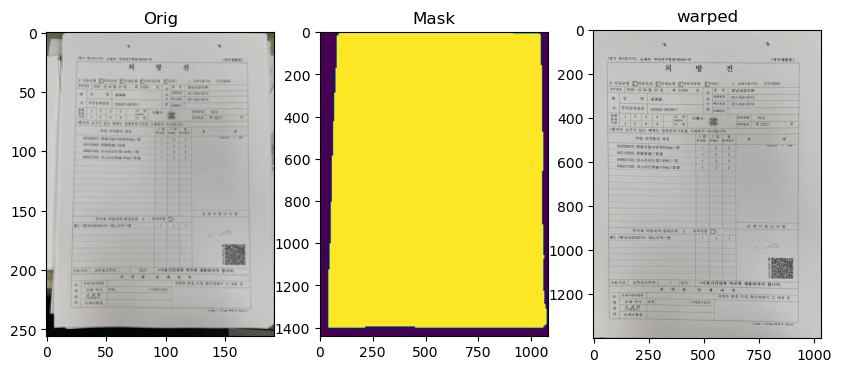

0.17699790000915527


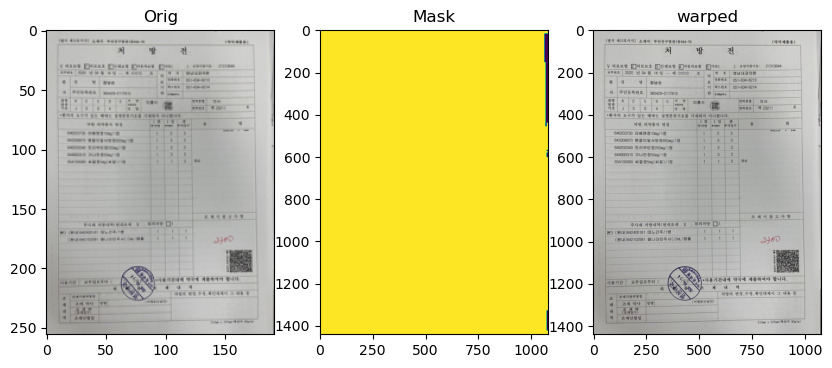

0.1499316692352295


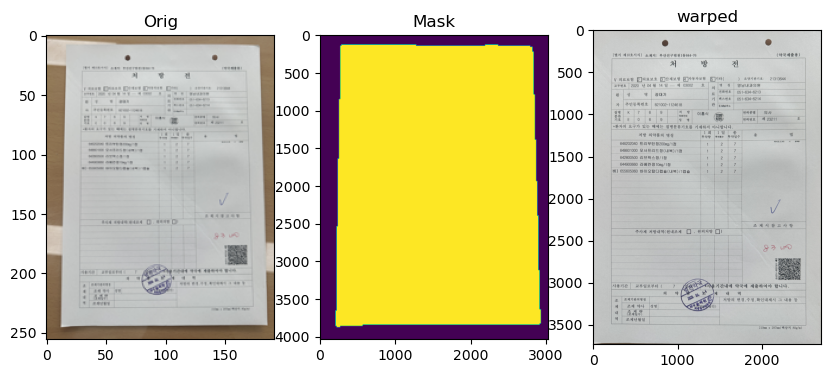

0.1538558006286621


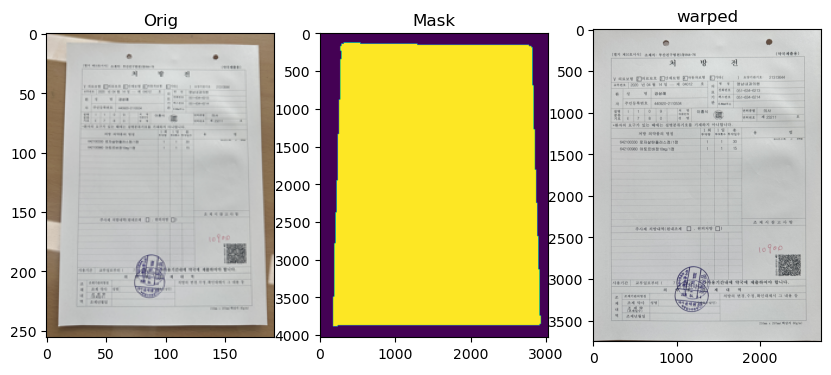

0.15714478492736816


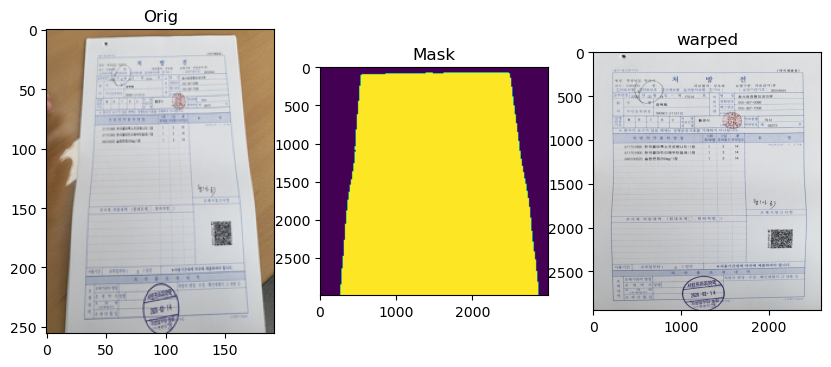

error: cannot identify image file 'C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/camera_good/강우신.HEIC' -- C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/camera_good/강우신.HEIC
0.1510758399963379


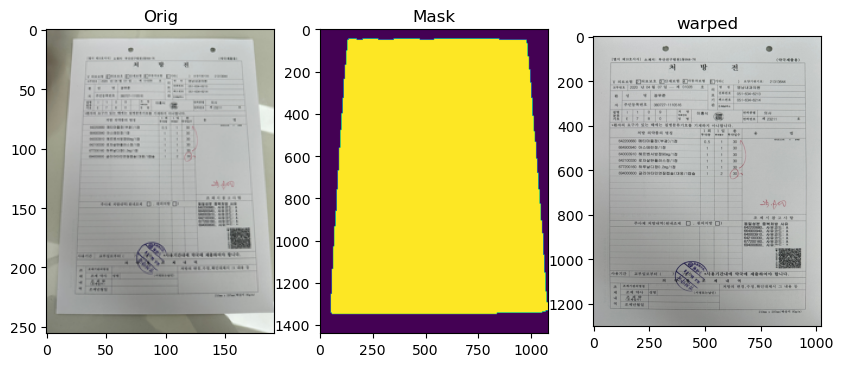

In [450]:
for count, test_img_path in enumerate(sorted(os.listdir(test_images_base_path))):

    try:
        orig_im = Image.open(f"{test_images_base_path}/{test_img_path}")
        orig_im = ImageOps.exif_transpose(orig_im)
        orig_y_px, orig_x_px = orig_im.size
        
        
        im = copy.deepcopy(orig_im)
        im = im.resize((num_pixels_y, num_pixels_x))
        im = np.array(im)
        orig_im = np.array(orig_im)

        image = loader(im)
        image = image.unsqueeze(0)


        with torch.no_grad():
            start = time.time()
            mask = segment_cpu_non_quant(image)
#             mask = mask > 0.5
            print(f"{time.time() - start}")

        mask_to_find = mask[0]
        mask_to_find = np.array(mask_to_find).astype(np.uint8)
        mask_to_find = Image.fromarray(mask_to_find[:, :, 0])
#         mask_to_find = Image.fromarray(mask_to_find[0, :, :])
        mask_to_find = mask_to_find.resize((orig_y_px, orig_x_px))
        mask_to_find = np.array(mask_to_find)
        
        contours, hierarchy = cv2.findContours(mask_to_find, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        simplified_contours = []
        warped = np.zeros((5, 5 ,3))
        try:
            for cnt in contours:
                hull = cv2.convexHull(cnt)
                simplified_contours.append(cv2.approxPolyDP(hull,
                                                            0.001 * cv2.arcLength(hull, True), True))
            biggest_n, approx_contour = biggest_contour(simplified_contours, 1000)

            warped = four_point_transform(orig_im, approx_contour)

    #         PIL_image = Image.fromarray(warped.astype('uint8'), 'RGB')
    #         PIL_image.save(f"{crop_images_save_path}/{test_img_path}")
        except Exception as e:
            print(f"error: {e} -- file: {test_img_path}")

        f, axarr = plt.subplots(1,3, figsize=(10,7))

        axarr[0].imshow(im)
        axarr[0].title.set_text('Orig')

        axarr[1].imshow(mask_to_find)
        axarr[1].title.set_text('Mask')

        axarr[2].imshow(warped, cmap='gray')
        axarr[2].title.set_text('warped')
        plt.show()
        
        if count > 5:
            break
    #break
    except Exception as e:
        print(f"error: {e} -- {test_images_base_path}/{test_img_path}")

In [451]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [452]:
base_path = './lite_weights'
torchscript_model = torch.jit.script(segment_cpu_non_quant)
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
#torch.jit.save(torchscript_model_optimized, "segmentation_model.ptl")
torchscript_model_optimized._save_for_lite_interpreter(f"{base_path}/segmentation_model_0412_256px_non_quant_case_1.ptl")

In [453]:
example = torch.rand(1, 3, num_pixels_x, num_pixels_y)
traced_script_module = torch.jit.trace(segment_cpu_non_quant, example)
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
#torch.jit.save(torchscript_model_optimized, "segmentation_model.ptl")
torchscript_model_optimized._save_for_lite_interpreter(f"{base_path}/segmentation_model_0412_256px_non_quant_case_2.ptl")

# Test model

In [144]:
loaded = torch.jit.load(f"{base_path}/segmentation_model_0409_256px_case1.ptl")
loaded.eval()

RecursiveScriptModule(original_name=QuantizedModel)

In [145]:
import time

start = time.time()
mask = loaded(image)
print(f"{time.time() - start}")

0.41059088706970215


In [ ]:
# 256 -- 0.0903
# 512 -- 0.3817

# 1. Illumination

In [181]:
torch.__version__

'1.12.1+cu116'

In [167]:
from models.u2net import REBNCONV, U2NETP
import copy

illuminate = U2NETP(out_ch=3)

illuminate_model_path = './weights/illumination_1600_good_0408_fin.pth'
illuminate.load_state_dict(torch.load(illuminate_model_path))


norm_mean = [ 0.485, 0.456, 0.406 ]
norm_std  = [ 0.229, 0.224, 0.225 ]

loader = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize(mean = norm_mean, std = norm_std),
])

In [168]:
illuminate_cpu = copy.deepcopy(illuminate.to('cpu'))
illuminate_cpu.eval()

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [169]:
class QuantizedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model_fp32 = model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        
        x = torch.permute(x, (0, 2,3, 1))
        x = self.dequant(x)
        return x
    
illuminate_cpu = QuantizedModel(illuminate_cpu)


In [170]:
for m in illuminate_cpu.modules():
    if type(m) == REBNCONV:
        torch.ao.quantization.fuse_modules(m, ['conv_s1', 'bn_s1', 'relu_s1'], inplace=True)

In [171]:
illuminate_cpu.qconfig = torch.quantization.get_default_qconfig('x86')
torch.quantization.prepare(illuminate_cpu, inplace=True)
torch.ao.quantization.convert(illuminate_cpu, inplace=True)

QuantizedModel(
  (model_fp32): U2NETP(
    (stage1): RSU7(
      (rebnconvin): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (bn_s1): Identity()
        (relu_s1): Identity()
      )
      (rebnconv1): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(64, 16, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (bn_s1): Identity()
        (relu_s1): Identity()
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv2): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1), scale=1.0, zero_point=0, padding=(1, 1))
        (bn_s1): Identity()
        (relu_s1): Identity()
      )
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (rebnconv3): REBNCONV(
        (conv_s1): QuantizedConvReLU2d(16, 16, kernel_size=(3, 3), stride=(1, 1

In [172]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [173]:
print("Size of model before quantization")
print_size_of_model(illuminate)

print("Size of model after quantization")
print_size_of_model(illuminate_cpu)

Size of model before quantization
Size (MB): 4.841989
Size of model after quantization
Size (MB): 1.330265


In [174]:
import time
# num_pixels_x, num_pixels_y = 256*2, 192*2
num_pixels_x, num_pixels_y = 1600, 1200

test_images_base_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/final_crop_good"

3.5039970874786377


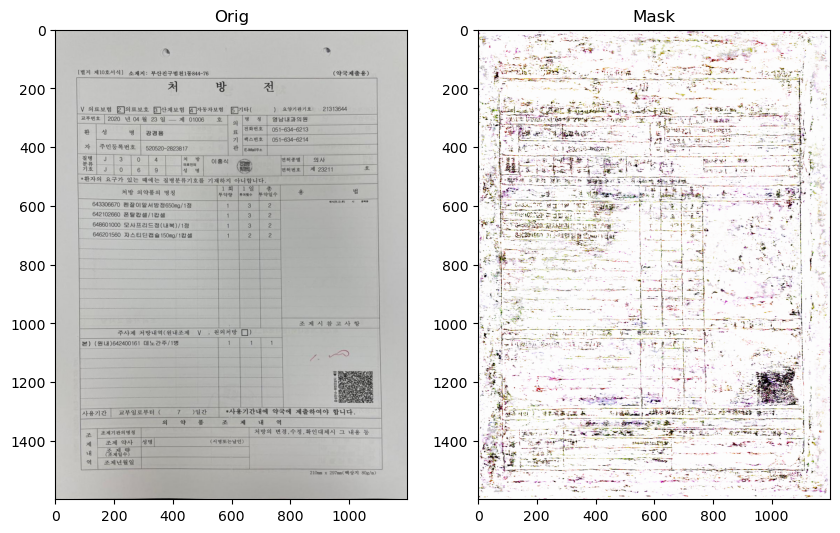

3.5785093307495117


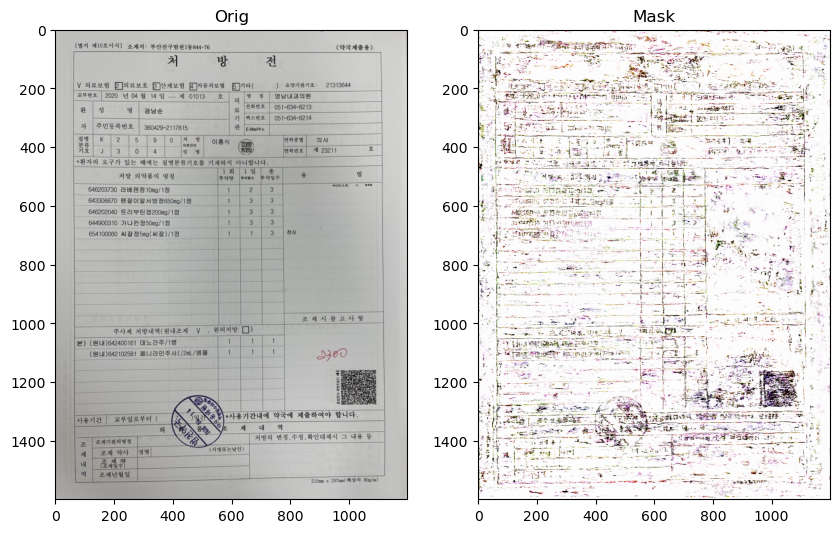

3.539996862411499


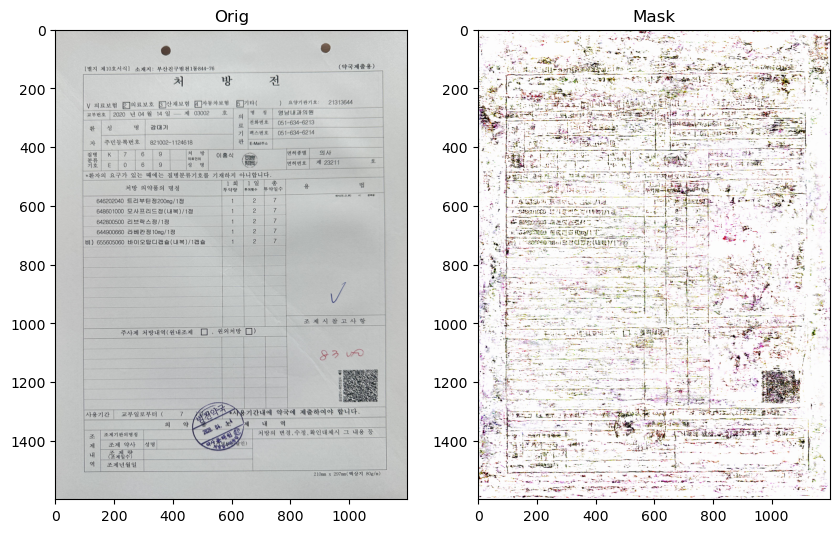

3.546266794204712


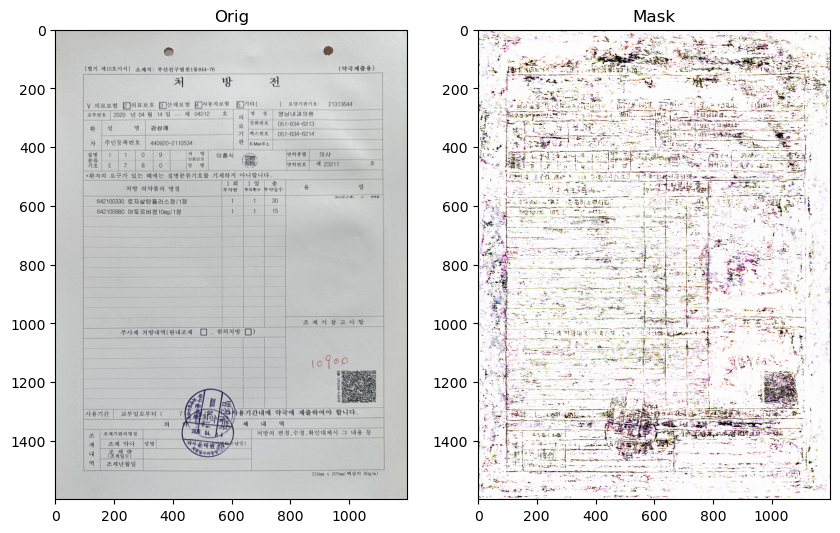

In [175]:
for count, test_img_path in enumerate(sorted(os.listdir(test_images_base_path))):

    try:
        im = Image.open(f"{test_images_base_path}/{test_img_path}")
        im = ImageOps.exif_transpose(im)
        im = im.resize((num_pixels_y, num_pixels_x))
        im = np.array(im)


        image = loader(im)
        image = image.unsqueeze(0)


        with torch.no_grad():
            start = time.time()
            rectified = illuminate_cpu(image)
            rectified = rectified[0]
            print(f"{time.time() - start}")


        f, axarr = plt.subplots(1,2, figsize=(10,7))

        axarr[0].imshow(im)
        axarr[0].title.set_text('Orig')

        axarr[1].imshow(rectified)
        axarr[1].title.set_text('Mask')

        plt.show()
        
        if count > 2:
            break
            
    except Exception as e:
        print(f"error: {e} -- {test_images_base_path}/{test_img_path}")

In [177]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [178]:
base_path = './lite_weights'
torchscript_model = torch.jit.script(illuminate_cpu)
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
#torch.jit.save(torchscript_model_optimized, "segmentation_model.ptl")
torchscript_model_optimized._save_for_lite_interpreter(f"{base_path}/illumination_model_0409_1600px_case1.ptl")

In [179]:
example = torch.rand(1, 3, num_pixels_x, num_pixels_y)
traced_script_module = torch.jit.trace(illuminate_cpu, example)
torchscript_model_optimized = optimize_for_mobile(torchscript_model)
#torch.jit.save(torchscript_model_optimized, "segmentation_model.ptl")
torchscript_model_optimized._save_for_lite_interpreter(f"{base_path}/illumination_model_0409_1600px_case2.ptl")

# Create minimal code

image.shape: torch.Size([1, 3, 512, 384])
0.6909937858581543
3.616750955581665


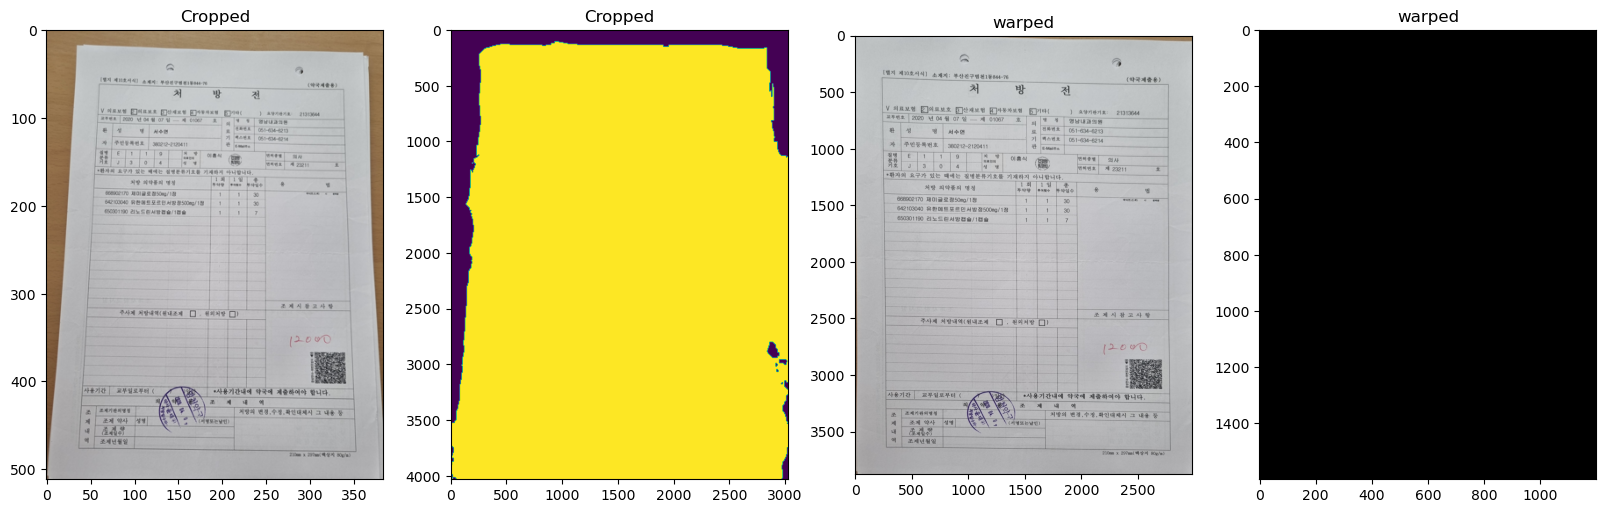

In [122]:
import time


#Initiazliation
segmentation_num_pixels_x, segmentation_num_pixels_y = 256*2, 192*2
illumination_num_pixels_x, illumination_num_pixels_y = 1600, 1200


test_img_path = "C:/Users/user/OneDrive - 성균관대학교/Desktop/HealthPort/illumination/camera_clean/서수연.jpg"

segmentation_model_path = "./lite_weights/segmentation_model_0409_512px_case1.ptl"
illumination_model_path = "./lite_weights/illumination_model_0409_1600px_case1.ptl"

norm_mean = [ 0.485, 0.456, 0.406 ]
norm_std  = [ 0.229, 0.224, 0.225 ]

loader = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize(mean = norm_mean, std = norm_std)])

start = time.time()
####################################
##### 0. Preprocess Segment ########
####################################

orig_im = Image.open(f"{test_img_path}")
orig_im = ImageOps.exif_transpose(orig_im)
orig_y_px, orig_x_px = orig_im.size
im = copy.deepcopy(orig_im)
im = im.resize((segmentation_num_pixels_y, segmentation_num_pixels_x))
im = np.array(im)

orig_im = np.array(orig_im)

####################################
######### 1. Segmentation ##########
####################################
image = loader(im)
image = image.unsqueeze(0)   
print(f"image.shape: {image.shape}")

segmentation_model = torch.jit.load(segmentation_model_path)
segmentation_model.eval()
mask_det = segmentation_model(image)

mask_to_find = mask_det[0]
mask_to_find = np.array(mask_to_find*255).astype(np.uint8)
mask_to_find = Image.fromarray(mask_to_find[:, :, 0])

mask_to_find = mask_to_find.resize((orig_y_px, orig_x_px))
mask_to_find = np.array(mask_to_find)
contours, hierarchy = cv2.findContours(mask_to_find, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

simplified_contours = []

for cnt in contours:
    hull = cv2.convexHull(cnt)
    simplified_contours.append(cv2.approxPolyDP(hull,
                                                0.001 * cv2.arcLength(hull, True), True))
biggest_n, approx_contour = biggest_contour(simplified_contours, 1000)

warped = four_point_transform(orig_im, approx_contour)
print(f"{time.time() - start}")


####################################
##### 2. Preprocess Segment ########
####################################

warped_im = Image.fromarray(warped)
warped_im = warped_im.resize((illumination_num_pixels_y, illumination_num_pixels_x))
warped_im = np.array(warped_im)
warped_im = loader(warped_im)
warped_im = warped_im.unsqueeze(0)  

####################################
######### 3. Illumination ##########
####################################

illumination_model = torch.jit.load(illumination_model_path)
illumination_model.eval()
rectified = illumination_model(warped_im)[0]
rectified = np.array(rectified)
print(f"{time.time() - start}")


####################################
######### 4. Post process ##########
####################################


f, axarr = plt.subplots(1,4, figsize=(20,7))

axarr[0].imshow(im)
axarr[0].title.set_text('Cropped')

axarr[1].imshow(mask_to_find)
axarr[1].title.set_text('Cropped')

axarr[2].imshow(warped, cmap='gray')
axarr[2].title.set_text('warped')

axarr[3].imshow(rectified)
axarr[3].title.set_text('warped')
plt.show()




In [129]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--test_img_path', type=str, default='./test.jpg', help='path to image to corrected')
parser.add_argument('--segmentation_model_path', type=str, default='./segmentation_model_0409_256px_case1.ptl', help='path to segmentation model')
parser.add_argument('--illumination_model_path', type=str, default='./illumination_model_0409_1600px_case1.ptl', help='path to illumination model')

parser.add_argument('--segmentation_num_pixels_x', type=int, default=256, help='number of pixels for segmentation X')
parser.add_argument('--segmentation_num_pixels_y', type=int, default=192, help='number of pixels for segmentation Y')

parser.add_argument('--illumination_num_pixels_x', type=int, default=1600, help='number of pixels for segmentation X')
parser.add_argument('--illumination_num_pixels_y', type=int, default=1200, help='number of pixels for segmentation Y')

parser.add_argument('--path_to_save_segmented_image', type=str, default='./output_segmented.jpg', help='path to save segmented image')
parser.add_argument('--path_to_save_corrected_image', type=str, default='./output_test.jpg', help='path to save corrected image')


#args = parser.parse_args()    
#args
#main(args)

_StoreAction(option_strings=['--path_to_save_corrected_image'], dest='path_to_save_corrected_image', nargs=None, const=None, default='./output_test.jpg', type=<class 'str'>, choices=None, required=False, help='path to save corrected image', metavar=None)

In [ ]:
PIL_image = Image.fromarray(warped.astype('uint8'), 'RGB')
PIL_image.save(f"{args.path_to_save_segmented_image}")
    
PIL_image = Image.fromarray(rectified.astype('uint8'), 'RGB')
PIL_image.save(f"{args.path_to_save_corrected_image}")

In [ ]:
#성정현_2
#조삼순
#황명자b_2

#권영규_2  -- ?